In [34]:
import cv2 as cv
import numpy as np
import time
import matplotlib.pyplot as plt
import logging


In [35]:
class ImageStitcher:
    def __init__(self, smoothing_window_size=500):
        self.smoothing_window_size = smoothing_window_size
        self.detector = cv.SIFT_create()
        self.matcher = cv.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
        
        # Set up logging for debugging and analytics
        logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(message)s')
        
    def create_mask(self, img1, img2, version):
        """Creates a blending mask for smooth transition."""
        height_img1, width_img1 = img1.shape[:2]
        height_img2, width_img2 = img2.shape[:2]

        height_panorama = max(height_img1, height_img2)
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = width_img1 - offset

        mask = np.zeros((height_panorama, width_panorama))

        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1

        return cv.merge([mask, mask, mask])
    def calculate_distance_transform(self,image):
        """Calculate distance transform of the image."""
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, binary = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
        dist_transform = cv.distanceTransform(binary, cv.DIST_L2, 5)
        return dist_transform
    def weighted_blend(self, panorama1, panorama2):
        """Blend two panoramas using weighted average of overlapping regions."""
        height, width = panorama1.shape[:2]
        
        # Step 1: Calculate distance transforms for both panoramas
        dist_transform1 = self.calculate_distance_transform(panorama1)
        dist_transform2 = self.calculate_distance_transform(panorama2)

        # Step 2: Initialize an empty result image
        result = np.zeros_like(panorama1)

        # Step 3: Loop over all pixels in the images
        for row in range(height):
            for col in range(width):
                pixel1 = panorama1[row, col]
                pixel2 = panorama2[row, col]

                # Get the distance transform values for the current pixel
                dist1 = dist_transform1[row, col]
                dist2 = dist_transform2[row, col]

                # Calculate the alpha value for weighted blending
                total_dist = dist1 + dist2
                alpha = dist1 / total_dist if total_dist != 0 else 0.5  # Handle divide by zero if no overlap

                # Apply the weighted blending formula
                result[row, col] = alpha * pixel1 + (1 - alpha) * pixel2

        return result

    def linear_blend(self, panorama1, panorama2, mask1, mask2):
        """Applies linear blending by gradually changing the contribution of each image."""
        # Define the blending region
        blended = np.zeros_like(panorama1)

        # Apply linear mask blending
        for y in range(panorama1.shape[0]):
            for x in range(panorama1.shape[1]):
                # Calculate the mask value based on x position (horizontal blending)
                alpha = (x - mask1.shape[1] // 2) / (mask1.shape[1] // 2)  # Change this for more control over blending

                # Clip alpha to ensure it's within valid range [0, 1]
                alpha = np.clip(alpha, 0, 1)

                # Linearly blend pixels based on alpha
                blended[y, x] = panorama1[y, x] * (1 - alpha) + panorama2[y, x] * alpha

        return blended

    def blending(self, H, img1, img2):
        """Applies linear blending after warping img2 onto img1."""
        height_img1, width_img1 = img1.shape[:2]
        height_img2, width_img2 = img2.shape[:2]

        height_panorama = max(height_img1, height_img2)
        width_panorama = width_img1 + width_img2 

        # Creating the panorama space
        panorama1 = np.zeros((height_panorama, width_panorama, 3))

        # Create blending masks
        mask1 = self.create_mask(img1, img2, version='left_image')
        mask2 = self.create_mask(img1, img2, version='right_image')

        # Place first image
        panorama1[:height_img1, :width_img1, :] = img1
        # panorama1 *= mask1

        # Warp second image using homography
        # panorama2 = cv.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
        panorama2 = cv.warpPerspective(img2, H, (width_panorama, height_panorama)) 

        # Linear Blend images
        result = panorama1 + panorama2

        # Weighted blending
        panorama1 = np.uint8(panorama1)  # Convert to 8-bit image
        panorama2 = np.uint8(panorama2)  # Convert to 8-bit image
        # Save panorama1 and panorama2 for debugging
        plt.imsave("panorama1.jpg", cv.cvtColor(panorama1, cv.COLOR_BGR2RGB))
        plt.imsave("panorama2.jpg", cv.cvtColor(panorama2, cv.COLOR_BGR2RGB))

        result = self.weighted_blend(panorama1, panorama2)

        #Linear gradient blending
        # result = self.linear_blend(panorama1, panorama2, mask1, mask2)
        

        # Crop black areas
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]

        return final_result, panorama1, panorama2
    def match_histograms(self, img1, img2):
        img1_yuv = cv.cvtColor(img1, cv.COLOR_BGR2YUV)
        img2_yuv = cv.cvtColor(img2, cv.COLOR_BGR2YUV)

        img1_yuv[:,:,0] = cv.equalizeHist(img1_yuv[:,:,0])
        img2_yuv[:,:,0] = cv.equalizeHist(img2_yuv[:,:,0])

        return cv.cvtColor(img1_yuv, cv.COLOR_YUV2BGR), cv.cvtColor(img2_yuv, cv.COLOR_YUV2BGR)
    def stitch_images(self, img1, img2):
        """Stitches two images using SIFT for feature detection."""
        img1, img2 = self.match_histograms(img1, img2)
        gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

        start_time = time.time()

        # Feature detection
        keypoints1, descriptors1 = self.detector.detectAndCompute(gray1, None)
        keypoints2, descriptors2 = self.detector.detectAndCompute(gray2, None)

        # Feature matching
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

        logging.debug(f"SIFT - Matches Found: {len(good_matches)}")

        if len(good_matches) < 10:
            raise ValueError("Not enough good matches found!")

        # Homography estimation
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, status = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)

        # Homography status analysis
        num_inliers = np.sum(status)
        num_outliers = len(status) - num_inliers
        logging.debug(f"Homography estimation: Inliers = {num_inliers}, Outliers = {num_outliers}")

        # Apply blending
        result, mask1, mask2 = self.blending(H, img1, img2)

        end_time = time.time()
        execution_time = end_time - start_time
        logging.debug(f"SIFT - Execution Time: {execution_time:.4f} seconds")

        return result, mask1, mask2, keypoints1, keypoints2, good_matches, execution_time, H

    def plot_feature_matching(self, img1, img2, keypoints1, keypoints2, good_matches):
        """Plots feature matching between two images."""
        img_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 10))
        plt.imshow(img_matches)
        plt.title("Feature Matching")
        plt.show()

    def plot_keypoints(self, img, keypoints):
        """Plot keypoints detected in an image."""
        img_keypoints = cv.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(10, 7))
        plt.imshow(img_keypoints)
        plt.title("Detected Keypoints")
        plt.show()

    def analyze_matches(self, good_matches, keypoints1, keypoints2):
        """Analysis of matches between keypoints."""
        match_distances = [m.distance for m in good_matches]
        avg_distance = np.mean(match_distances)
        max_distance = np.max(match_distances)
        min_distance = np.min(match_distances)

        logging.debug(f"Match analysis: Avg distance = {avg_distance:.4f}, Max distance = {max_distance:.4f}, Min distance = {min_distance:.4f}")

        return avg_distance, max_distance, min_distance

2025-02-17 16:23:57,936 - SIFT - Matches Found: 549
2025-02-17 16:23:57,965 - Homography estimation: Inliers = 198, Outliers = 351
2025-02-17 16:30:39,015 - SIFT - Execution Time: 425.5008 seconds
2025-02-17 16:30:39,133 - Execution Time: 425.5008 seconds
2025-02-17 16:30:39,136 - Homography Matrix: 
[[-6.45723960e-02 -9.63488812e-02  3.63504940e+03]
 [-3.99010099e-01  8.79452059e-01  2.30428865e+02]
 [-2.64790641e-04 -2.39699187e-05  1.00000000e+00]]


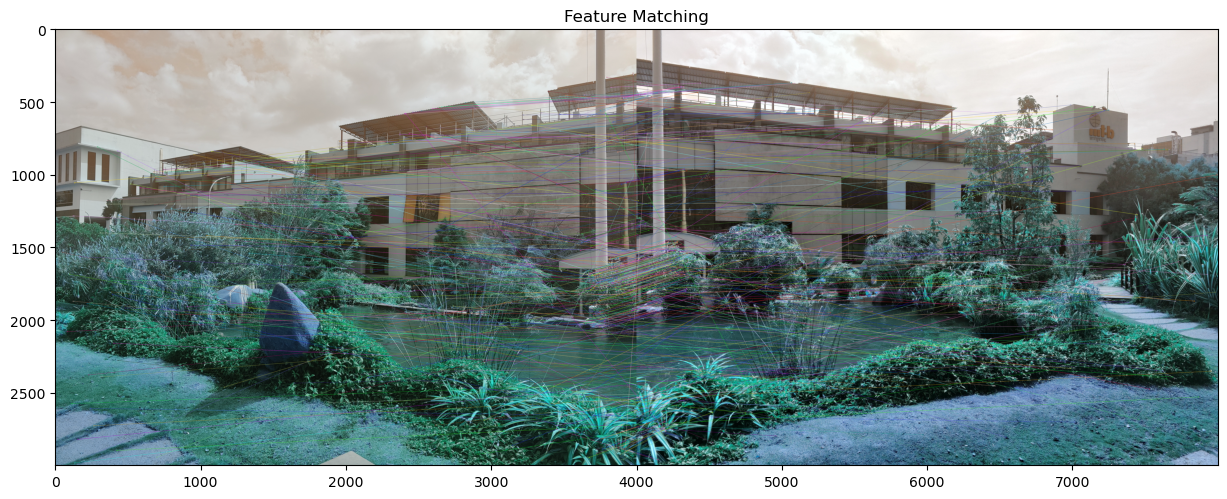

In [36]:

# Load images
img1 = cv.imread('IIITB1.jpeg')
img2 = cv.imread('IIITB2.jpeg')

if img1 is None or img2 is None:
    raise FileNotFoundError("Error: One or both images could not be loaded!")

# Initialize the ImageStitcher
stitcher = ImageStitcher()

# Stitch images using SIFT
stitched_image, mask1, mask2, keypoints1, keypoints2, good_matches, execution_time, Homography = stitcher.stitch_images(img1, img2)
# log execution time and H
logging.debug(f"Execution Time: {execution_time:.4f} seconds")
logging.debug(f"Homography Matrix: \n{Homography}")
# Plot intermediate feature matching
stitcher.plot_feature_matching(img1, img2, keypoints1, keypoints2, good_matches)

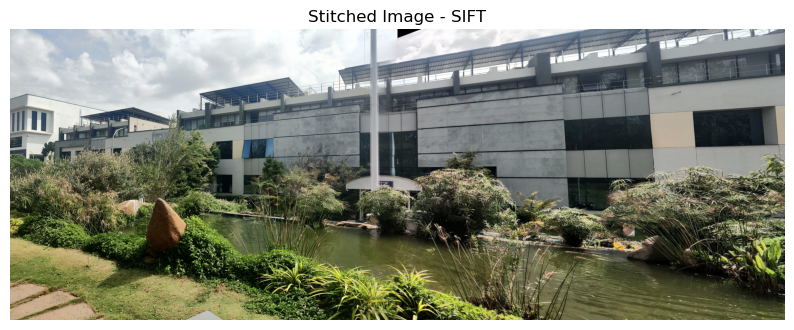

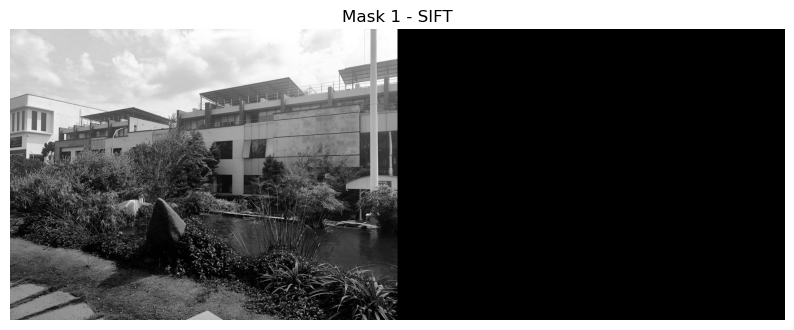

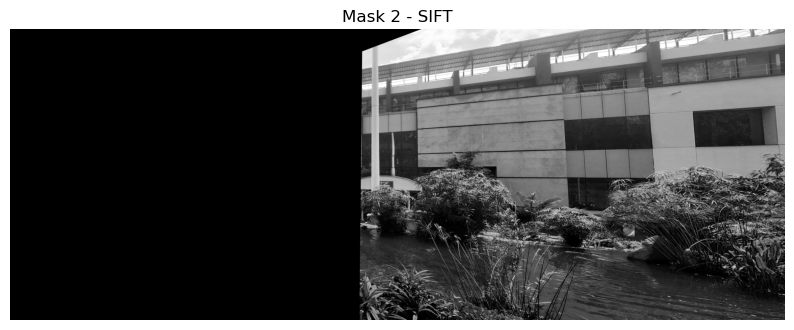

In [37]:
# stitched_image = np.clip(stitched_image, 0, 255)
# Plot stitched image
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title("Stitched Image - SIFT")
plt.axis('off')  # Turn off axis
plt.show()

# Plot Mask 1 - SIFT
plt.figure(figsize=(10, 8))
plt.imshow(mask1[:, :, 0], cmap='gray')  # Display only one channel (as mask is grayscale)
plt.title("Mask 1 - SIFT")
plt.axis('off')  # Turn off axis
plt.show()

# Plot Mask 2 - SIFT
plt.figure(figsize=(10, 8))
plt.imshow(mask2[:, :, 0], cmap='gray')  # Display only one channel (as mask is grayscale)
plt.title("Mask 2 - SIFT")
plt.axis('off')  # Turn off axis
plt.show()

# Show the images
cv.waitKey(0)
cv.destroyAllWindows()
